# **CAPSTONE PROJECT III**

**JCDSOL - 013 - 026 Dhiyafath Anargyo Orion**

# Context

Sebuah hotel menganalisa database mereka untuk dijadikan acuan sebuah pelanggan akan membatalkan bookingan atau tidak. hal ini bertujuan untuk mengurangi ketidak efektifan dalam hal operational cost maupun kekurangan operational cost yang disebabkan oleh miskalkulasi terhadap keramaian/tingkat ketersediaan kamar

* Target
    - 0 = not Canceled (Customer yang sudah melakukan booking hotel **tidak membatalkan bookingnya**)
    - 1 = is canceled (Customer yang sudah melakukan booking hotel **membatalkan bookingnya**)

* Problem = 
    Management hotel menyiapkan perlengkapan kamar, service untuk customer yang berlebihan. hal ini disebabkan oleh adanya customer yang membatalkan bookingan yang mempengaruhi terhadap operational cost yang dapat ditekan untuk lebih efektif

* Goals = 
    membuat sebuah model yang dapat memprediksi customer yang membatalkan/tidak membatalkan bookingan. dan menganalisa faktor/feature apa saja yang mempengaruhi customer membatalkan bookingan

# Evaluation Metrics

* Evaluation Metrics
    - True Positive     : Model memprediksi customer akan **membatalkan booking**, kenyataanya **dibatalkan**
    - True Negative     : Model memprediksi customer **tidak akan membatalkan booking**, kenyataanya **tidak dibatalkan**
    - False Positive    : Model memprediksi customer akan **membatalkan booking**, kenyataanya **tidak dibatalkan**
    - False Negative    : Model memprediksi customer **tidak akan membatalkan booking**, kenyataanya **dibatalkan**

* Consequences
    - False Positive    : Akan ada kekurangan dalam bentuk operasional yang sudah disediakan (misal bahan makanan, peralatan) bahkan bisa jadi kamar sedang tidak tersedia dikarenakan sedang dilakukan banyak maintenance
    - False Negative    : Sudah menyiapkan operasional untuk high/peak season namun banyak customer yang membatalkan bookingan hotel

sehingga kedua konsekuensi ini dianggap sangat berpengaruh terhadap efektivitas operational cost dan penentuan jadwal maintenance

# Import Libraries

In [52]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno

from scipy.stats import stats, spearmanr, shapiro, mannwhitneyu, chi2_contingency

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, RobustScaler
from category_encoders import BinaryEncoder
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import train_test_split, StratifiedKFold

from sklearn.model_selection import cross_val_score, KFold
from sklearn.pipeline import Pipeline

from imblearn.pipeline import Pipeline as ImbPipeline 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler, NearMiss
from imblearn.over_sampling import RandomOverSampler, SMOTE

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier
from xgboost import XGBClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix

import pickle

import warnings
warnings.filterwarnings('ignore')

# Data Understanding

## Read Dataset 

In [2]:
df = pd.read_csv('data_hotel_booking_demand.csv')
df

,country,market_segment,previous_cancellations,booking_changes,deposit_type,days_in_waiting_list,customer_type,reserved_room_type,required_car_parking_spaces,total_of_special_requests,is_canceled
0,IRL,Offline TA/TO,0,0,No Deposit,0,Transient-Party,A,0,0,0
1,FRA,Online TA,0,0,No Deposit,0,Transient,A,0,2,0
2,PRT,Online TA,0,1,No Deposit,0,Transient,A,0,2,0
3,NLD,Online TA,0,0,No Deposit,0,Transient,A,0,1,1
4,PRT,Online TA,0,2,No Deposit,0,Transient,A,0,2,0
...,...,...,...,...,...,...,...,...,...,...,...
83568,PRT,Online TA,0,0,No Deposit,0,Contract,A,0,3,1
83569,FRA,Online TA,0,0,No Deposit,0,Transient,D,0,2,0
83570,PRT,Online TA,0,1,No Deposit,0,Transient,D,0,3,0
83571,CN,Offline TA/TO,0,0,No Deposit,0,Transient-Party,A,0,0,0


## Data Types

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83573 entries, 0 to 83572
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   country                      83222 non-null  object
 1   market_segment               83573 non-null  object
 2   previous_cancellations       83573 non-null  int64 
 3   booking_changes              83573 non-null  int64 
 4   deposit_type                 83573 non-null  object
 5   days_in_waiting_list         83573 non-null  int64 
 6   customer_type                83573 non-null  object
 7   reserved_room_type           83573 non-null  object
 8   required_car_parking_spaces  83573 non-null  int64 
 9   total_of_special_requests    83573 non-null  int64 
 10  is_canceled                  83573 non-null  int64 
dtypes: int64(6), object(5)
memory usage: 7.0+ MB


## Data Features

| Attribute                 | Data Type           | Description                                         |
|---------------------------|---------------------|-----------------------------------------------------|
|country                    |str	              |Negara Asal Pelanggan                                |
|market_segment             |str                  |Segmen Pasar                                         |
|previous_cancellations     |int64	              |Frekuensi melakukan pembatalan pemesanan             |
|booking_changes            |int64	              |Frekuensi melakukan perubahan pemesanan              |
|deposit_type	            |str	              |Tipe deposit                                         |
|days_in_waiting_list	    |int64	              |Hari menunggu dalam waiting list                     |
|customer_type	            |str	              |Tipe pemesanan                                       |
|reserved_room_type	        |str	              |Tipe kamar yang disewa                               |
|required_car_parking_space	|int64	              |Jumlah perminataan lahan parkir                      |
|total_of_special_request	|int64	              |Permintaan Tambahan                                  |
|is_canceled        	    |int64                |Pembatalan pemesanan, 0 – Tidak batal, 1 – Batal     |

## Unique Values

In [4]:
pd.set_option('display.max_colwidth', None)
# data uni di tiap kolom
listItem = []
for col in df.columns :
    listItem.append( [col, df[col].nunique(), df[col].unique()])

tabel1Desc = pd.DataFrame(columns=['Column Name', 'Number of Unique', 'Unique Sample'],
                     data=listItem)
tabel1Desc

,Column Name,Number of Unique,Unique Sample
0,country,162,"[IRL, FRA, PRT, NLD, ESP, UMI, CN, LUX, BRA, BEL, JPN, DEU, ITA, CHE, GBR, AGO, SRB, COL, CHN, SWE, AUT, CIV, CZE, POL, USA, SGP, RUS, ROU, DNK, IND, MAR, PHL, ARG, ISL, ZAF, LBN, MOZ, TUR, BGD, MEX, CAF, NOR, FIN, UKR, EGY, ISR, nan, KOR, AZE, HUN, AUS, EST, CHL, SVN, PRY, ABW, ALB, LTU, ARE, HRV, SAU, NZL, LVA, ATA, KAZ, DZA, TWN, CRI, BIH, BGR, IRQ, OMN, VEN, IDN, GEO, MLT, IRN, BLR, URY, LBY, TUN, BEN, MYS, MWI, GRC, CYP, CPV, HKG, PRI, MKD, MUS, IMN, PAN, NGA, GLP, KHM, PER, QAT, SEN, MAC, ...]"
1,market_segment,8,"[Offline TA/TO, Online TA, Direct, Groups, Corporate, Complementary, Aviation, Undefined]"
2,previous_cancellations,15,"[0, 1, 25, 2, 3, 11, 24, 13, 6, 26, 14, 4, 19, 5, 21]"
3,booking_changes,19,"[0, 1, 2, 5, 3, 4, 6, 7, 9, 8, 17, 10, 13, 12, 14, 21, 16, 20, 15]"
4,deposit_type,3,"[No Deposit, Non Refund, Refundable]"
5,days_in_waiting_list,115,"[0, 3, 39, 87, 77, 215, 97, 162, 46, 79, 4, 31, 122, 34, 57, 259, 50, 17, 32, 43, 75, 69, 44, 22, 113, 58, 38, 65, 48, 236, 176, 25, 108, 91, 19, 160, 68, 28, 63, 35, 42, 59, 24, 8, 183, 187, 21, 111, 56, 98, 101, 15, 16, 47, 93, 45, 14, 70, 10, 49, 178, 99, 60, 40, 85, 223, 6, 33, 391, 20, 1, 41, 147, 55, 80, 379, 150, 61, 330, 174, 107, 96, 18, 62, 13, 30, 120, 27, 207, 71, 2, 76, 125, 5, 9, 224, 53, 83, 84, 12, ...]"
6,customer_type,4,"[Transient-Party, Transient, Contract, Group]"
7,reserved_room_type,10,"[A, E, D, F, B, G, C, H, L, P]"
8,required_car_parking_spaces,5,"[0, 1, 2, 8, 3]"
9,total_of_special_requests,6,"[0, 2, 1, 3, 4, 5]"


## Check Missing Values

<Axes: >

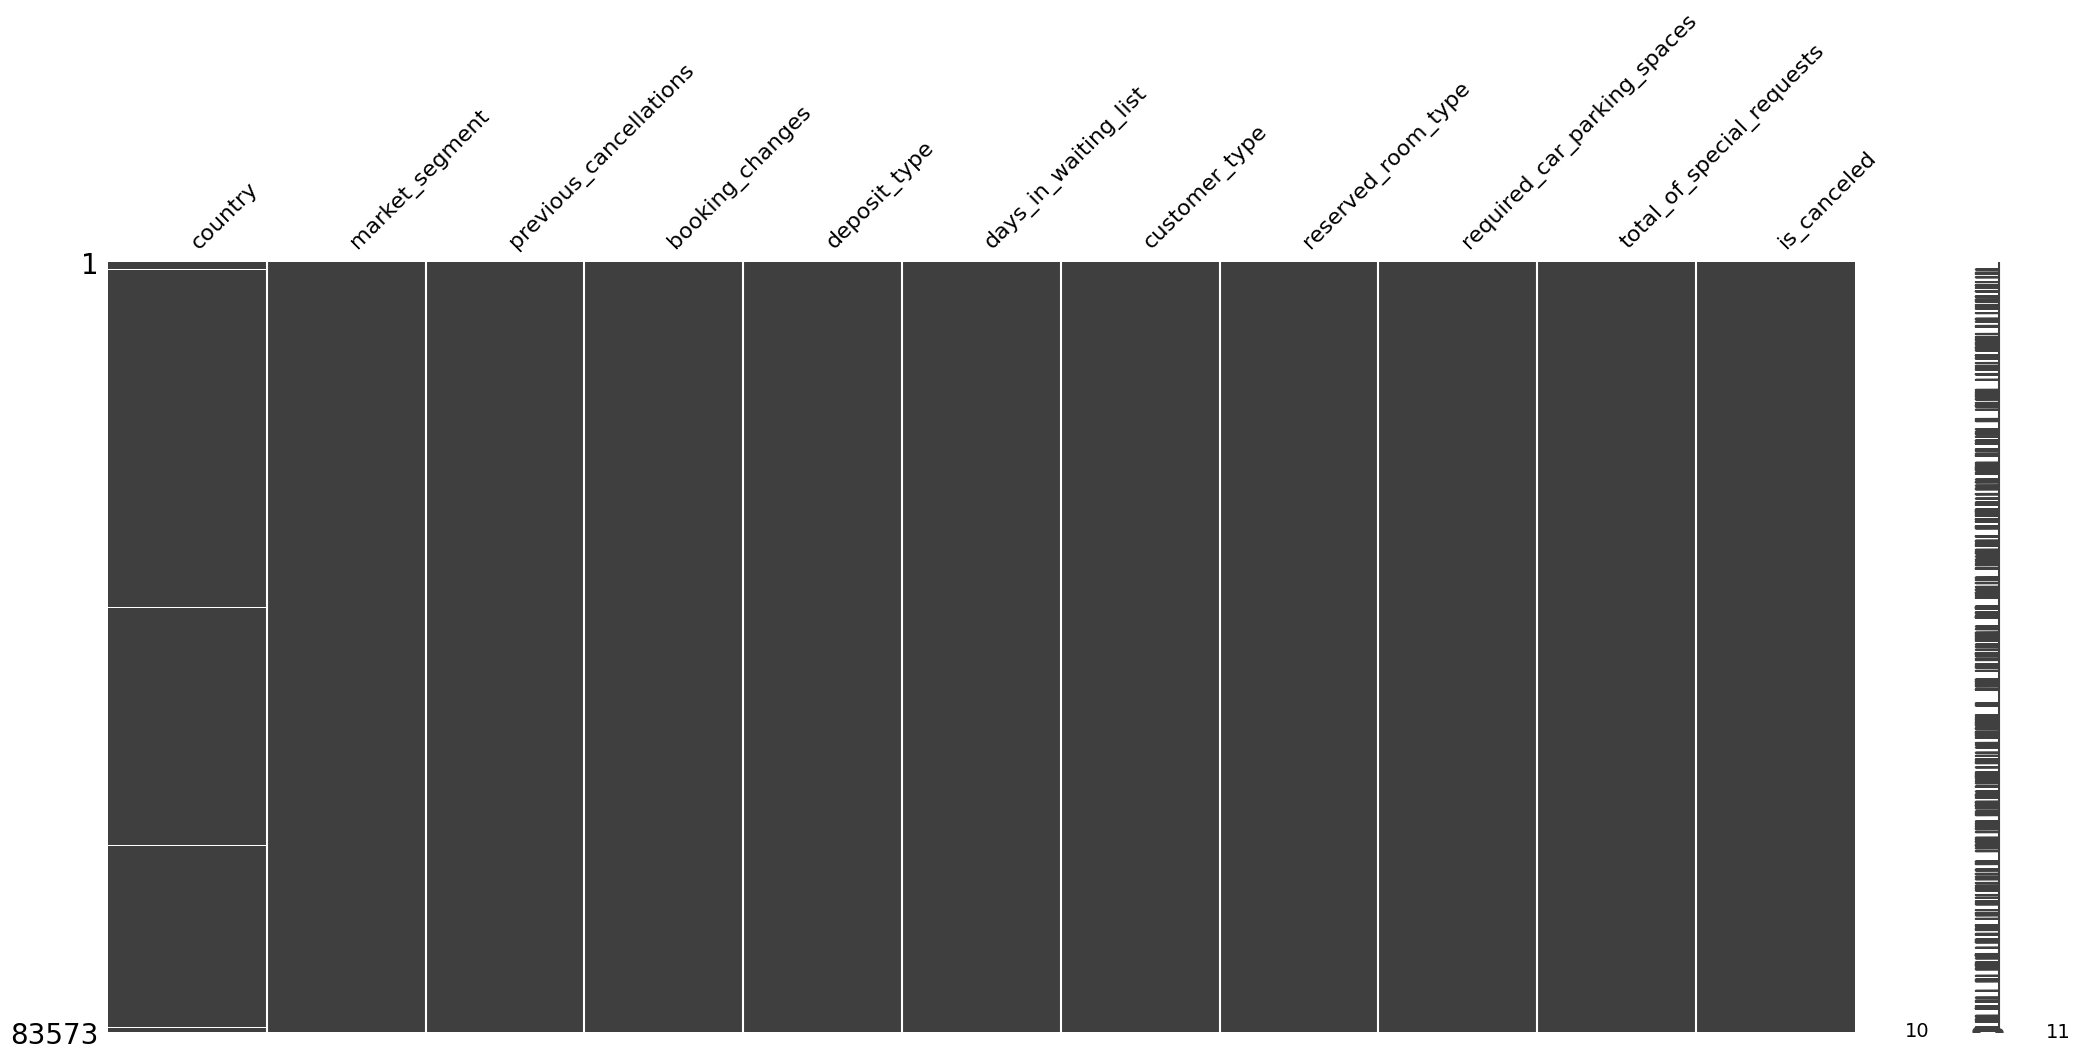

In [5]:
msno.matrix(df)

In [6]:
listItem = []
for col in df.columns :
    listItem.append([col, df[col].dtype, df[col].isna().sum(), round((df[col].isna().sum()/len(df[col])) * 100,2),
                    df[col].nunique(), list(df[col].drop_duplicates().sample(2).values)])

dfDesc = pd.DataFrame(columns=['dataFeatures', 'dataType', 'null', 'nullPct', 'unique', 'uniqueSample'],
                     data=listItem)
dfDesc

,dataFeatures,dataType,null,nullPct,unique,uniqueSample
0,country,object,351,0.42,162,"[CHL, JPN]"
1,market_segment,object,0,0.00,8,"[Groups, Aviation]"
2,previous_cancellations,int64,0,0.00,15,"[19, 3]"
3,booking_changes,int64,0,0.00,19,"[1, 3]"
4,deposit_type,object,0,0.00,3,"[Non Refund, Refundable]"
5,days_in_waiting_list,int64,0,0.00,115,"[79, 193]"
6,customer_type,object,0,0.00,4,"[Transient, Contract]"
7,reserved_room_type,object,0,0.00,10,"[H, G]"
8,required_car_parking_spaces,int64,0,0.00,5,"[3, 2]"
9,total_of_special_requests,int64,0,0.00,6,"[3, 5]"


In [7]:
df.describe()

,previous_cancellations,booking_changes,days_in_waiting_list,required_car_parking_spaces,total_of_special_requests,is_canceled
count,83573.000000,83573.000000,83573.000000,83573.000000,83573.000000,83573.000000
mean,0.086798,0.220897,2.330561,0.062999,0.573211,0.368277
std,0.841011,0.648635,17.673051,0.246919,0.795163,0.482340
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
max,26.000000,21.000000,391.000000,8.000000,5.000000,1.000000


## Check Outliers

In [8]:
numerik = df.select_dtypes(include=['int64'])

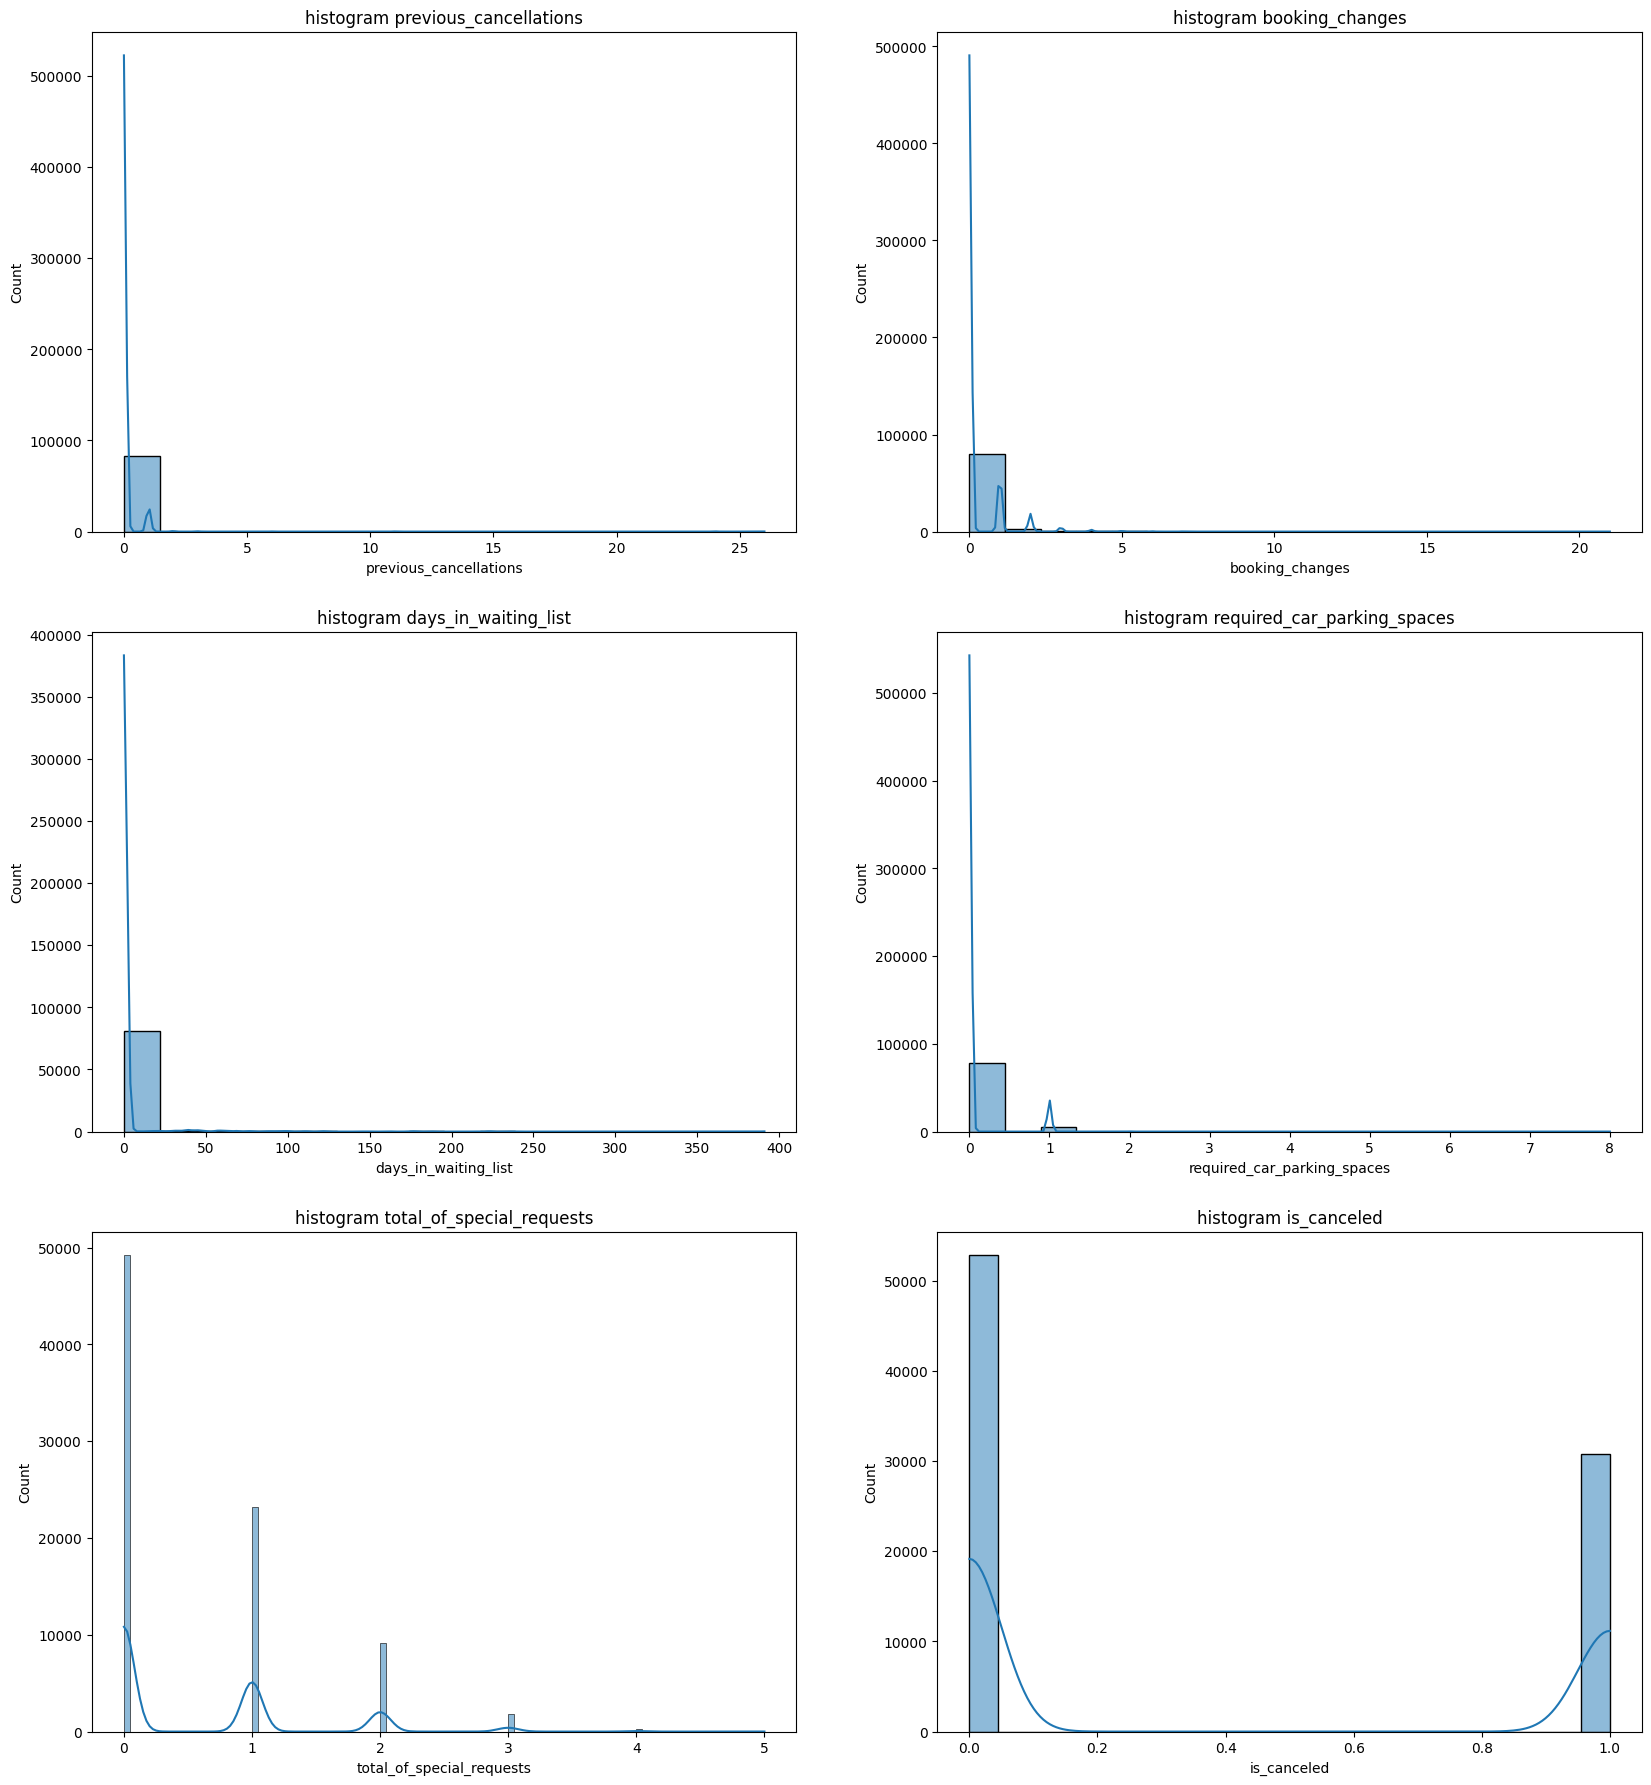

In [9]:
fig = plt.figure(figsize=(20,100)) # horizontal, vertikal

count = 0
for kolom in numerik.columns:
    count += 1
    plt.subplot(13,2,count)
    sns.histplot(numerik[kolom], kde=True)
    plt.title(f"histogram {kolom}")
plt.show()

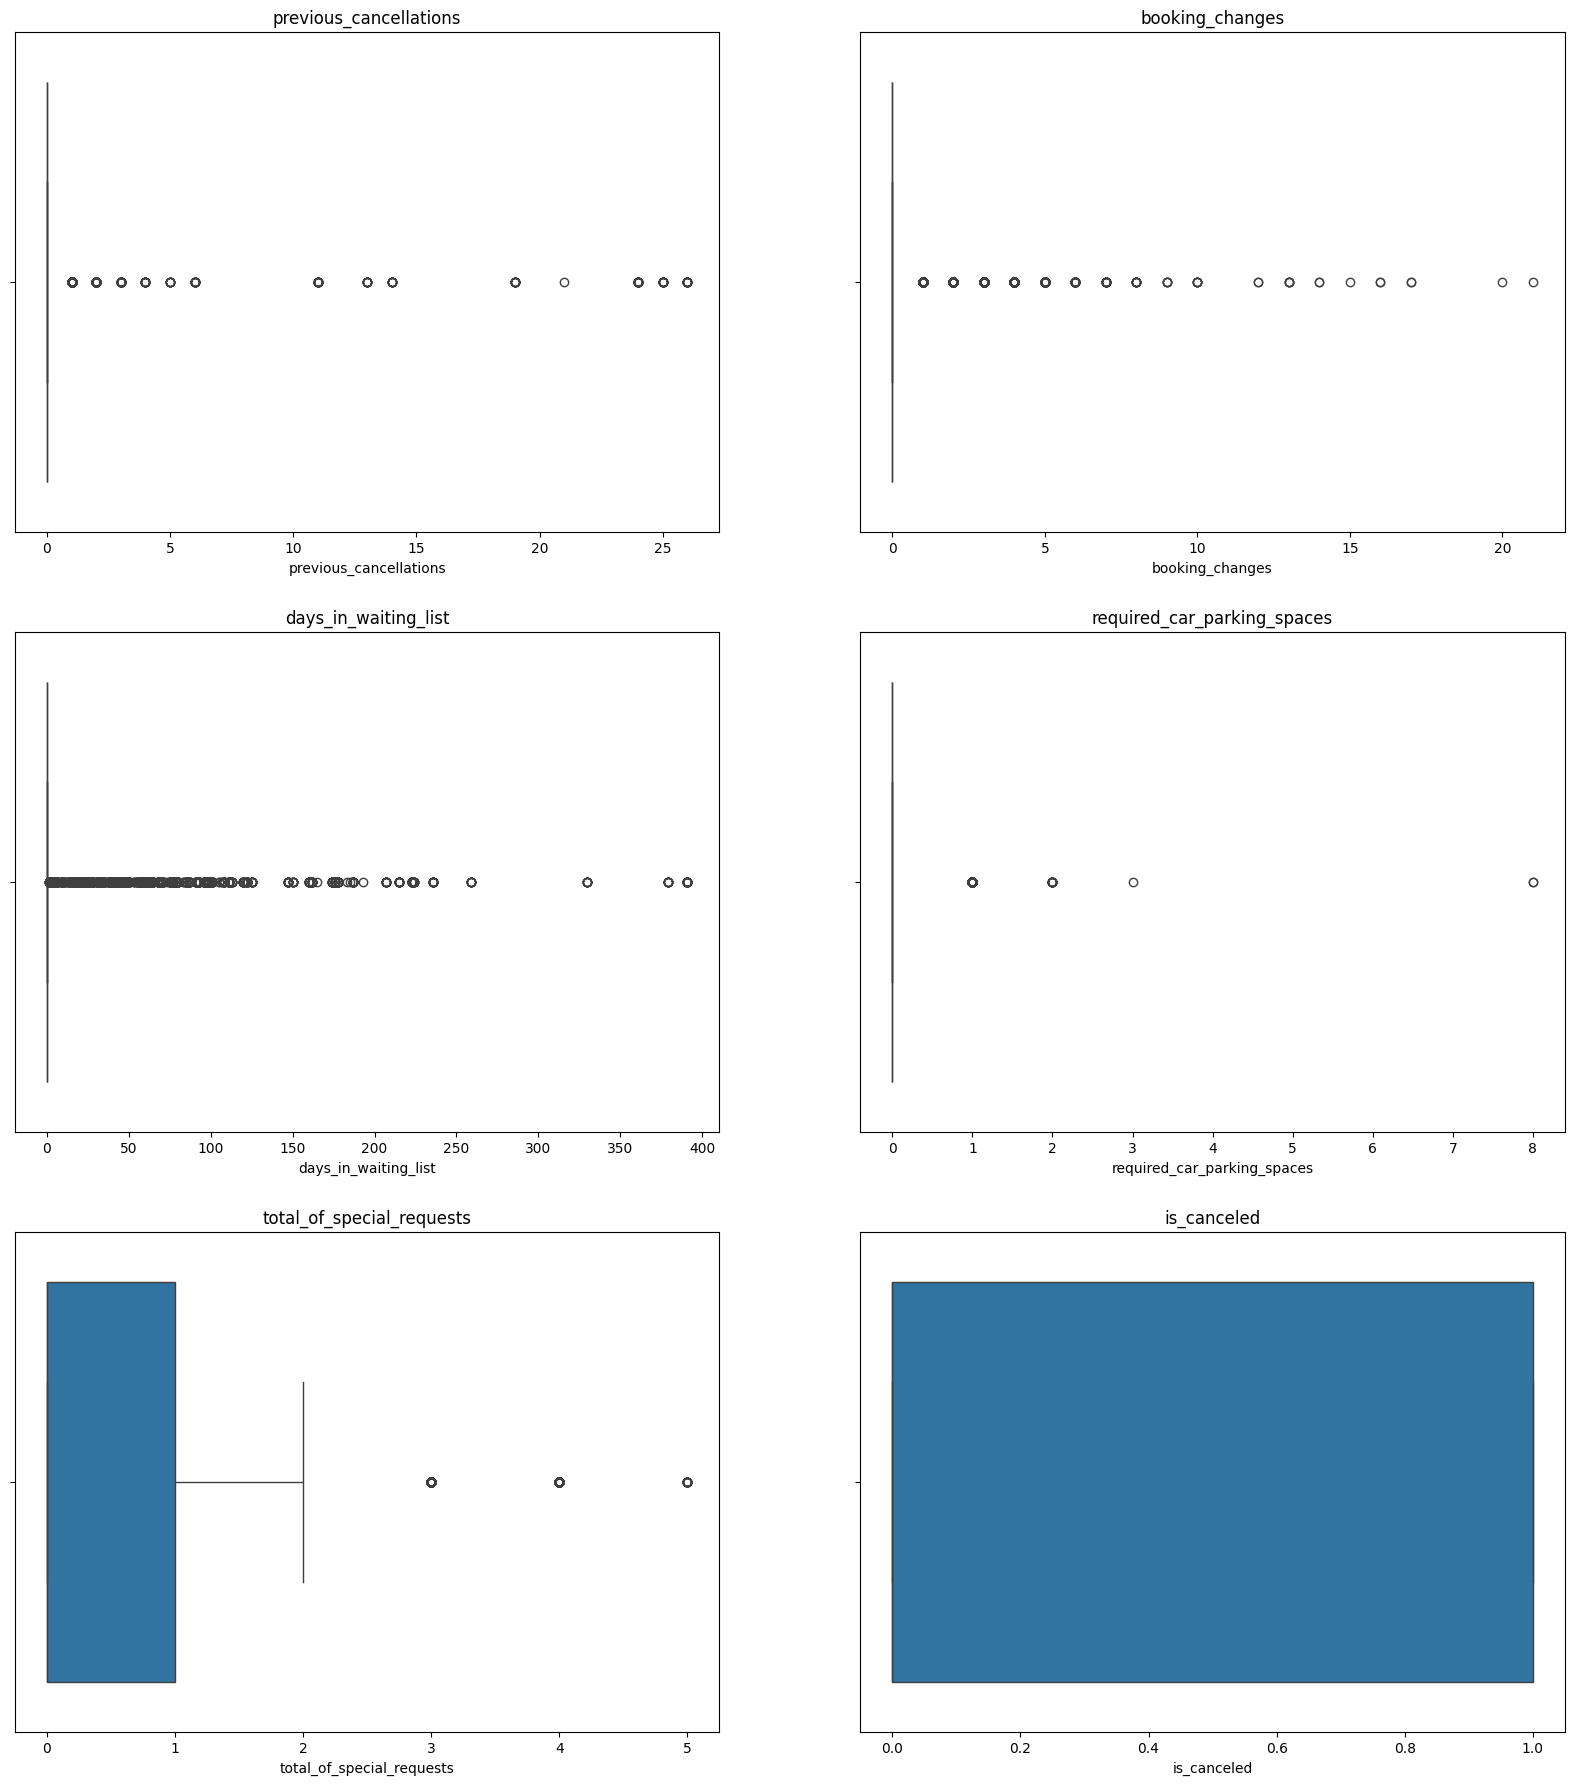

In [10]:
fig = plt.figure(figsize=(20,100)) # horizontal, vertikal

count = 0
for kolom in numerik.columns:
    count += 1
    plt.subplot(13,2,count)
    sns.boxplot(numerik, x = kolom)
    plt.title(f'{kolom}')
plt.show()

* there are some outliers from 'days_in_waiting_list' feature
* there are some outliers from 'required_parking_spaces' feature

## Correlation

In [11]:
numerik.corr()

,previous_cancellations,booking_changes,days_in_waiting_list,required_car_parking_spaces,total_of_special_requests,is_canceled
previous_cancellations,1.000000,-0.027361,0.006895,-0.018208,-0.048026,0.109598
booking_changes,-0.027361,1.000000,-0.010687,0.068508,0.055748,-0.145746
days_in_waiting_list,0.006895,-0.010687,1.000000,-0.030333,-0.083275,0.056203
required_car_parking_spaces,-0.018208,0.068508,-0.030333,1.000000,0.083678,-0.194807
total_of_special_requests,-0.048026,0.055748,-0.083275,0.083678,1.000000,-0.235993
is_canceled,0.109598,-0.145746,0.056203,-0.194807,-0.235993,1.000000


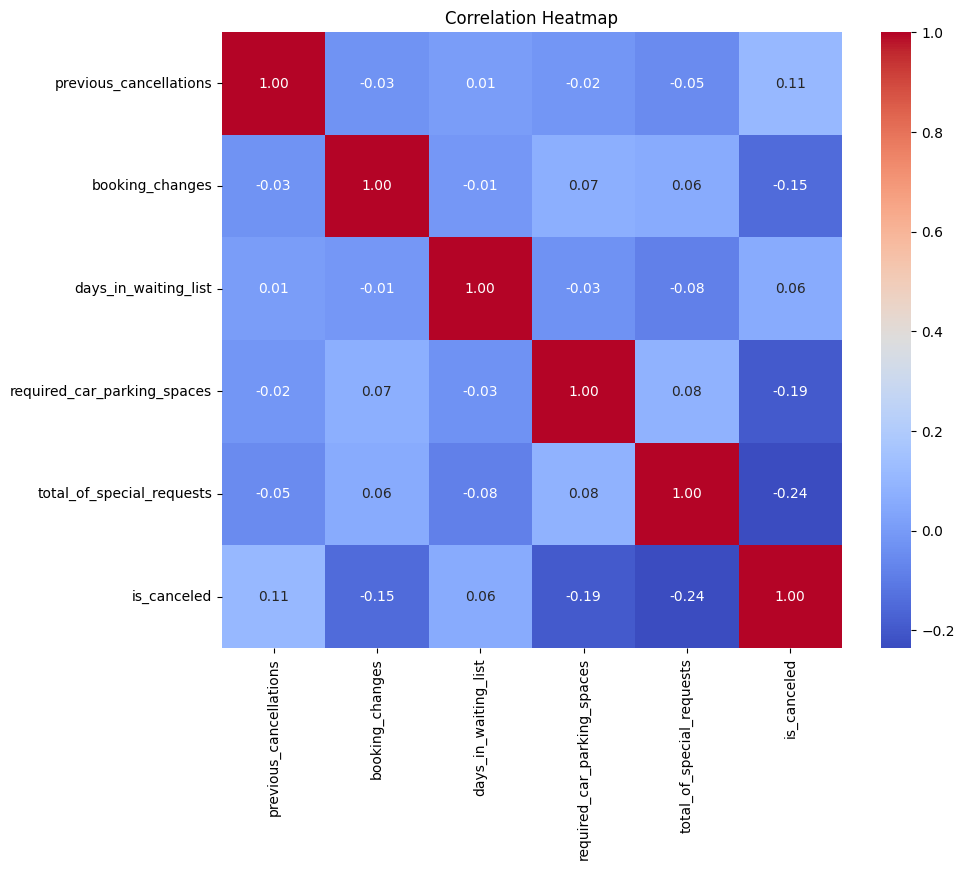

In [12]:
correlation_matrix = numerik.corr()

# Creating the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

## Imbalance

In [13]:
(df['is_canceled'].value_counts()/len(df))*100

is_canceled
0    63.172316
1    36.827684
Name: count, dtype: float64

## Summary Data Understanding

- Dataset terdiri dari +/- 83.000 data customer dengan 10 features yang menjadi acuan ke target 'is_canceled' 0 (tidak) atau 1 (iya)
- Terdapat missing values di kolom/feature country
- terdapat outliers di kolom/feature 'days_in_waiting_list' dan 'required_parking_spaces'
- data tidak balence (imbalance) perlu dilakukan balancing untuk training data

# Data Pre-Processing

## Data Cleaning

In [14]:
dfClean = df.copy()

### Handling Missing Values

In [15]:
naCountry = dfClean['country'].isna().sum()

In [16]:
print(f'Jumlah Missing Values di kolom Country : {naCountry} ')

Jumlah Missing Values di kolom Country : 351 


In [17]:
naPctCountry = (dfClean['country'].isna().sum()/len(df))*100

In [18]:
print(f'Presentase Missing Values di kolom Country : {naPctCountry:.3f} % dari keseluruhan data')

Presentase Missing Values di kolom Country : 0.420 % dari keseluruhan data


Karena data missing values sebesar 0.4% dari keseluruhan data, data dapat di drop

In [19]:
dfClean.dropna(inplace=True)

In [20]:
dfClean.isna().sum()

country                        0
market_segment                 0
previous_cancellations         0
booking_changes                0
deposit_type                   0
days_in_waiting_list           0
customer_type                  0
reserved_room_type             0
required_car_parking_spaces    0
total_of_special_requests      0
is_canceled                    0
dtype: int64

## Remove Outliers

In [21]:
outliers_days = dfClean[(dfClean['days_in_waiting_list'] >300)]
outliers_days

,country,market_segment,previous_cancellations,booking_changes,deposit_type,days_in_waiting_list,customer_type,reserved_room_type,required_car_parking_spaces,total_of_special_requests,is_canceled
5970,PRT,Groups,0,0,Non Refund,391,Transient,A,0,0,1
6788,PRT,Groups,0,0,Non Refund,391,Transient,A,0,0,1
7227,PRT,Groups,0,0,Non Refund,391,Transient,A,0,0,1
8063,FRA,Groups,0,1,No Deposit,379,Transient-Party,A,0,1,0
10448,FRA,Groups,0,0,No Deposit,330,Transient-Party,A,0,0,0
11062,PRT,Groups,0,0,No Deposit,379,Transient-Party,A,0,0,1
13567,PRT,Groups,0,0,Non Refund,391,Transient,A,0,0,1
15129,PRT,Groups,0,0,Non Refund,391,Transient,A,0,0,1
18005,PRT,Groups,0,0,Non Refund,391,Transient,A,0,0,1
18075,FRA,Groups,0,0,No Deposit,330,Transient-Party,A,0,0,0


In [22]:
dropWL = dfClean.drop(dfClean[dfClean['days_in_waiting_list'] > 300].index,inplace=True)

In [23]:
dfClean

,country,market_segment,previous_cancellations,booking_changes,deposit_type,days_in_waiting_list,customer_type,reserved_room_type,required_car_parking_spaces,total_of_special_requests,is_canceled
0,IRL,Offline TA/TO,0,0,No Deposit,0,Transient-Party,A,0,0,0
1,FRA,Online TA,0,0,No Deposit,0,Transient,A,0,2,0
2,PRT,Online TA,0,1,No Deposit,0,Transient,A,0,2,0
3,NLD,Online TA,0,0,No Deposit,0,Transient,A,0,1,1
4,PRT,Online TA,0,2,No Deposit,0,Transient,A,0,2,0
...,...,...,...,...,...,...,...,...,...,...,...
83568,PRT,Online TA,0,0,No Deposit,0,Contract,A,0,3,1
83569,FRA,Online TA,0,0,No Deposit,0,Transient,D,0,2,0
83570,PRT,Online TA,0,1,No Deposit,0,Transient,D,0,3,0
83571,CN,Offline TA/TO,0,0,No Deposit,0,Transient-Party,A,0,0,0


In [24]:
outliers_parking = dfClean[(dfClean['required_car_parking_spaces'] >4)]
outliers_parking

,country,market_segment,previous_cancellations,booking_changes,deposit_type,days_in_waiting_list,customer_type,reserved_room_type,required_car_parking_spaces,total_of_special_requests,is_canceled
21979,AUT,Direct,0,1,No Deposit,122,Transient-Party,E,8,0,0
35802,AUT,Direct,0,1,No Deposit,0,Transient-Party,E,8,1,0


In [25]:
dropParking = dfClean.drop(dfClean[dfClean['required_car_parking_spaces'] > 4].index,inplace=True)

In [26]:
dfClean

,country,market_segment,previous_cancellations,booking_changes,deposit_type,days_in_waiting_list,customer_type,reserved_room_type,required_car_parking_spaces,total_of_special_requests,is_canceled
0,IRL,Offline TA/TO,0,0,No Deposit,0,Transient-Party,A,0,0,0
1,FRA,Online TA,0,0,No Deposit,0,Transient,A,0,2,0
2,PRT,Online TA,0,1,No Deposit,0,Transient,A,0,2,0
3,NLD,Online TA,0,0,No Deposit,0,Transient,A,0,1,1
4,PRT,Online TA,0,2,No Deposit,0,Transient,A,0,2,0
...,...,...,...,...,...,...,...,...,...,...,...
83568,PRT,Online TA,0,0,No Deposit,0,Contract,A,0,3,1
83569,FRA,Online TA,0,0,No Deposit,0,Transient,D,0,2,0
83570,PRT,Online TA,0,1,No Deposit,0,Transient,D,0,3,0
83571,CN,Offline TA/TO,0,0,No Deposit,0,Transient-Party,A,0,0,0


### Data Cleaning Output

In [27]:
dfCleaned = pd.DataFrame(dfClean)
csv = 'dfCleaned.csv'
dfCleaned.to_csv('dfCleaned.csv', index=False)

## Summary Data Cleaning

- terdapat 351 data missing values di kolom country karena country bukan sebuah numerik dan tidak dapat didefinisikan maka di drop selain itu missing values hanya sejumlah 0.42% dari keseluruhan data
- menghapus data pada feature waiting list yang lebih dari 300 hari
- menghapus data pada feature required parking spaces yang lebih dari 4 hari

## Normality Test

objectives = normality test is used to check what is the best scaling method 

### Previous Cancellations

In [28]:
shapiro_test = shapiro(dfCleaned['previous_cancellations'])
print("Shapiro-Wilk Test:")
print("Statistic:", shapiro_test[0], "p-value:", shapiro_test[1])

# Interpret the p-value
alpha = 0.05
if shapiro_test[1] > alpha:
    print('Distribusi normal(fail to reject H0)')
else:
    print('Tidak berdistribusi normal (reject H0)')

Shapiro-Wilk Test:
Statistic: 0.06607328062550888 p-value: 1.0612071771767603e-176
Tidak berdistribusi normal (reject H0)


### Booking Changes

In [29]:
shapiro_test = shapiro(dfCleaned['booking_changes'])
print("Shapiro-Wilk Test:")
print("Statistic:", shapiro_test[0], "p-value:", shapiro_test[1])

# Interpret the p-value
alpha = 0.05
if shapiro_test[1] > alpha:
    print('Distribusi normal(fail to reject H0)')
else:
    print('Tidak berdistribusi normal (reject H0)')

Shapiro-Wilk Test:
Statistic: 0.37716987279584024 p-value: 4.9298062593185204e-163
Tidak berdistribusi normal (reject H0)


### Days in Waiting List

In [30]:
shapiro_test = shapiro(dfCleaned['days_in_waiting_list'])
print("Shapiro-Wilk Test:")
print("Statistic:", shapiro_test[0], "p-value:", shapiro_test[1])

# Interpret the p-value
alpha = 0.05
if shapiro_test[1] > alpha:
    print('Distribusi normal(fail to reject H0)')
else:
    print('Tidak berdistribusi normal (reject H0)')

Shapiro-Wilk Test:
Statistic: 0.12516746890856079 p-value: 1.8559723627730873e-174
Tidak berdistribusi normal (reject H0)


### Required Car Parking Spaces

In [31]:
shapiro_test = shapiro(dfCleaned['required_car_parking_spaces'])
print("Shapiro-Wilk Test:")
print("Statistic:", shapiro_test[0], "p-value:", shapiro_test[1])

# Interpret the p-value
alpha = 0.05
if shapiro_test[1] > alpha:
    print('Distribusi normal(fail to reject H0)')
else:
    print('Tidak berdistribusi normal (reject H0)')

Shapiro-Wilk Test:
Statistic: 0.2573800454775561 p-value: 6.710419009495129e-169
Tidak berdistribusi normal (reject H0)


### Total of Special Requests

In [32]:
shapiro_test = shapiro(dfCleaned['total_of_special_requests'])
print("Shapiro-Wilk Test:")
print("Statistic:", shapiro_test[0], "p-value:", shapiro_test[1])

# Interpret the p-value
alpha = 0.05
if shapiro_test[1] > alpha:
    print('Distribusi normal(fail to reject H0)')
else:
    print('Tidak berdistribusi normal (reject H0)')

Shapiro-Wilk Test:
Statistic: 0.7173839903686412 p-value: 5.615909111234947e-138
Tidak berdistribusi normal (reject H0)


### Normality Test Results

Normality test results = non-normally distributed, use Robust Scaler

## Correlation

Objectives = Correlation is used to Select Features that will be used

### Numerik

is_canceled                    1.000000
previous_cancellations         0.109598
days_in_waiting_list           0.056203
booking_changes               -0.145746
required_car_parking_spaces   -0.194807
total_of_special_requests     -0.235993
Name: is_canceled, dtype: float64


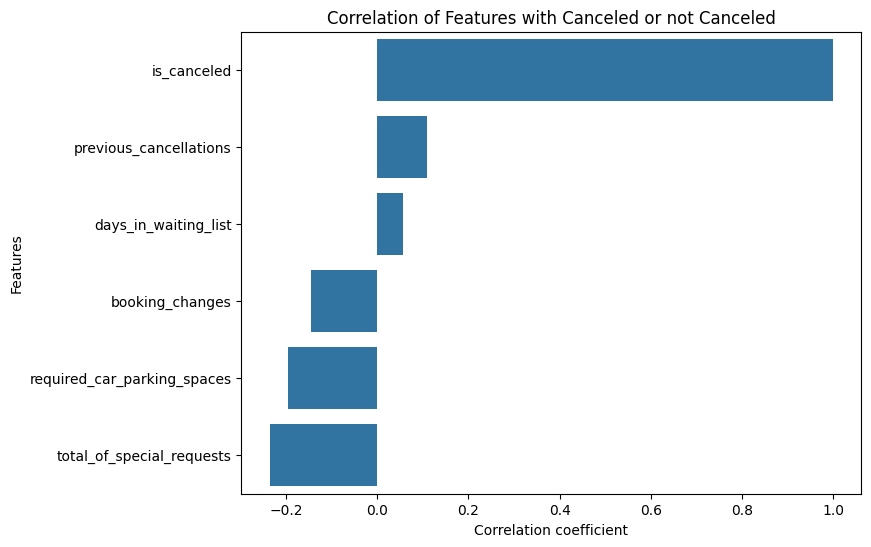

In [51]:
numCorr = correlation_matrix['is_canceled'].sort_values(ascending=False)

print(numCorr)

plt.figure(figsize=(8, 6))
sns.barplot(x=numCorr.values, y=numCorr.index)
plt.title('Correlation of Features with Canceled or not Canceled')
plt.xlabel('Correlation coefficient')
plt.ylabel('Features')
plt.show()

In [34]:
intColumns = ['previous_cancellations','booking_changes','days_in_waiting_list','required_car_parking_spaces','total_of_special_requests']

for col in intColumns:
    corr, p_value = spearmanr(df[col], df['is_canceled'])

    if p_value < 0.05:
        print(f"{col} vs is_canceled:\nCorrelation: {corr:.4f} | P-value: {p_value:.4g} (significant)\n")
    else:
        print(f"{col} vs is_canceled:\nCorrelation: {corr:.4f} | P-value: {p_value:.4g} (not significant)\n")

previous_cancellations vs is_canceled:
Correlation: 0.2699 | P-value: 0 (significant)

booking_changes vs is_canceled:
Correlation: -0.1849 | P-value: 0 (significant)

days_in_waiting_list vs is_canceled:
Correlation: 0.1008 | P-value: 1.055e-187 (significant)

required_car_parking_spaces vs is_canceled:
Correlation: -0.1972 | P-value: 0 (significant)

total_of_special_requests vs is_canceled:
Correlation: -0.2594 | P-value: 0 (significant)



### Kategorik

In [35]:
table_country = pd.crosstab(dfCleaned['country'], dfCleaned['is_canceled'])

chi2_country, p_country, dof_country, expected_country = chi2_contingency(table_country)

print(f"Chi-squared Test for country and is_canceled:")
print(f"Chi-squared Statistic: {chi2_country}, p-value: {p_country}")

Chi-squared Test for country and is_canceled:
Chi-squared Statistic: 10638.453822572676, p-value: 0.0


In [36]:
table_market = pd.crosstab(dfCleaned['market_segment'], dfCleaned['is_canceled'])

chi2_market, p_market, dof_market, expected_market = chi2_contingency(table_market)

print(f"Chi-squared Test for market_segment and is_canceled:")
print(f"Chi-squared Statistic: {chi2_market}, p-value: {p_market}")

Chi-squared Test for market_segment and is_canceled:
Chi-squared Statistic: 5988.043908113579, p-value: 0.0


In [37]:
table_deposit = pd.crosstab(dfCleaned['deposit_type'], dfCleaned['is_canceled'])

chi2_deposit, p_deposit, dof_deposit, expected_deposit = chi2_contingency(table_deposit)

print(f"Chi-squared Test for market_segment and is_canceled:")
print(f"Chi-squared Statistic: {chi2_deposit}, p-value: {p_deposit}")

Chi-squared Test for market_segment and is_canceled:
Chi-squared Statistic: 19196.92136635912, p-value: 0.0


In [38]:
table_cust = pd.crosstab(dfCleaned['customer_type'], dfCleaned['is_canceled'])

chi2_cust, p_cust, dof_cust, expected_cust = chi2_contingency(table_cust)

print(f"Chi-squared Test for market_segment and is_canceled:")
print(f"Chi-squared Statistic: {chi2_cust}, p-value: {p_cust}")

Chi-squared Test for market_segment and is_canceled:
Chi-squared Statistic: 1504.2302658599715, p-value: 0.0


In [39]:
table_cust = pd.crosstab(dfCleaned['customer_type'], dfCleaned['is_canceled'])

chi2_cust, p_cust, dof_cust, expected_cust = chi2_contingency(table_cust)

print(f"Chi-squared Test for market_segment and is_canceled:")
print(f"Chi-squared Statistic: {chi2_cust}, p-value: {p_cust}")

Chi-squared Test for market_segment and is_canceled:
Chi-squared Statistic: 1504.2302658599715, p-value: 0.0


### Correlation Results

Results = all of the features can be used because of significant with the data

## Feature Engineering

### Encoding and Scaling

In [40]:
preprocessor = ColumnTransformer(
    transformers=[
        ('ohe', OneHotEncoder(handle_unknown='ignore'), ['market_segment', 'deposit_type']),
        ('binary', BinaryEncoder(), ['country', 'market_segment', 'reserved_room_type']),
        ('rob', RobustScaler(), ['previous_cancellations', 'booking_changes', 'days_in_waiting_list', 'required_car_parking_spaces','total_of_special_requests'])
    ])

| Attribute                 | Data Type           | Encoder         |Scaler     |
|---------------------------|---------------------|-----------------|-----------|
|country                    |str	              |Binary           |           |
|market_segment             |str                  |Binary           |           |
|previous_cancellations     |int64	              |                 |Robust     |
|booking_changes            |int64	              |                 |Robust     |
|deposit_type	            |str	              |OHE              |           |
|days_in_waiting_list	    |int64	              |                 |Robust     |
|customer_type	            |str	              |OHE              |           |
|reserved_room_type	        |str	              |Binary           |           |
|required_car_parking_space	|int64	              |                 |Robust     |
|total_of_special_request	|int64	              |                 |Robust     |

### Resampling

Resampling digunakan untuk menyeimbangi data yang imbalanced

In [41]:
x = dfCleaned.drop(['is_canceled'], axis=1)
y = dfCleaned['is_canceled']

xtrain, xtest, ytrain, ytest = train_test_split(
    x,
    y, 
    test_size=0.2, 
    random_state=2024)

#### Resampling Benchmarking

In [42]:
resampling_methods = {
    'RandomUnderSampler': RandomUnderSampler(random_state=2024),
    'RandomOverSampler': RandomOverSampler(random_state=2024),
    'SMOTE': SMOTE(random_state=2024),
    'NearMiss': NearMiss(),
}

results = {}

for name, method in resampling_methods.items():
    pipeline = ImbPipeline([
        ('preprocessing', preprocessor),
        ('Resampling', method),
        ('RandomForest', RandomForestClassifier())
    ])
    
    # Fitting
    pipeline.fit(xtrain, ytrain)
    pred = pipeline.predict(xtest)

    f1 = f1_score(ytest, pred, average='binary', pos_label=1)  
    results[name] = f1

for resampling_method, f1 in results.items():
    print(f'{resampling_method}: {f1:.4f}')

RandomUnderSampler: 0.7269
RandomOverSampler: 0.7258
SMOTE: 0.7279
NearMiss: 0.6312


# Model Benchmarking

In [43]:
logreg = LogisticRegression(max_iter=1000)
knn = KNeighborsClassifier()
dt = DecisionTreeClassifier()
forest = RandomForestClassifier()
ada = AdaBoostClassifier()
gbc = GradientBoostingClassifier()
xgb = XGBClassifier()

models = [logreg, knn, dt, forest, ada, gbc, xgb]
model_names = ['Logistic Regression', 'KNN', 'Decision Tree', 'Random Forest', 'Ada Boost', 'Gradient Boost','XGB']
f1_scores_list = []
stds = []

kfold = KFold(n_splits=5, shuffle=True, random_state=2024)

for model in models:
    model_pipeline = ImbPipeline(steps=[('preprocessor', preprocessor),
                                        ('smote', SMOTE(random_state=2024)),
                                        ('classifier', model)])
    
    cv_scores = cross_val_score(model_pipeline, xtrain, ytrain, cv=kfold, scoring='f1')
   
    f1_scores = cv_scores
    f1_scores_list.append(f1_scores.mean())
    stds.append(f1_scores.std())

df_benchmark = pd.DataFrame({
    'Model': model_names,
    'AVG F1': f1_scores_list,
    'STD F1': stds
})

df_benchmark.sort_values('AVG F1', ascending=False)

,Model,AVG F1,STD F1
6,XGB,0.735979,0.004402
3,Random Forest,0.730732,0.004180
5,Gradient Boost,0.729439,0.003868
2,Decision Tree,0.728503,0.003990
4,Ada Boost,0.692403,0.003741
0,Logistic Regression,0.682406,0.003921
1,KNN,0.680096,0.010793


# Hyperparameter Tuning

In [44]:
rdf_pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=2024)),
    ('rdf', RandomForestClassifier(random_state=2024))
])

# Define the parameter grid
param_grid = {
    'rdf__n_estimators': [100, 200, 300],
    'rdf__max_depth': [None, 10, 20, 30],
    'rdf__min_samples_split': [2, 5, 10],
    'rdf__min_samples_leaf': [1, 2, 4]
}

# Initialize GridSearchCV
grid_search = GridSearchCV(rdf_pipeline, param_grid, cv=5, scoring='f1', verbose=2, n_jobs=-1)

# Fit GridSearchCV
grid_search.fit(xtrain, ytrain)

# Print best parameters and best score
print("Best parameters:", grid_search.best_params_)
print("Best cross-validated F1 score:", grid_search.best_score_)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best parameters: {'rdf__max_depth': None, 'rdf__min_samples_leaf': 2, 'rdf__min_samples_split': 2, 'rdf__n_estimators': 300}
Best cross-validated F1 score: 0.7352281704204017


In [45]:
xgb_pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=2024)),
    ('xgb', XGBClassifier(random_state=2024))
])

# Define the parameter grid
param_grid = {
    'xgb__n_estimators': [100, 200, 300],
    'xgb__max_depth': [3, 6, 9],
    'xgb__learning_rate': [0.01, 0.1, 0.2],
    'xgb__subsample': [0.6, 1.0]
}

# Initialize GridSearchCV
grid_search = GridSearchCV(xgb_pipeline, param_grid, cv=5, scoring='f1', verbose=2, n_jobs=-1)

# Fit GridSearchCV
grid_search.fit(xtrain, ytrain)

# Print best parameters and best score
print("Best parameters:", grid_search.best_params_)
print("Best cross-validated F1 score:", grid_search.best_score_)

Fitting 5 folds for each of 54 candidates, totalling 270 fits
Best parameters: {'xgb__learning_rate': 0.1, 'xgb__max_depth': 9, 'xgb__n_estimators': 200, 'xgb__subsample': 1.0}
Best cross-validated F1 score: 0.7361027338456486


Best parameters yang akan digunakan untuk Final Model: 
- 'xgb__max_depth': None, 
- 'xgb__learning_rate': 0.1, 
- 'xgb__n_estimators': 300, 
- 'xgb__subsample': 0.8

# Final Model

Final Model Test F1 Score: 0.7072
Final Model Test Accuracy: 0.8029
Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.89      0.85     10577
           1       0.77      0.65      0.71      6057

    accuracy                           0.80     16634
   macro avg       0.79      0.77      0.78     16634
weighted avg       0.80      0.80      0.80     16634



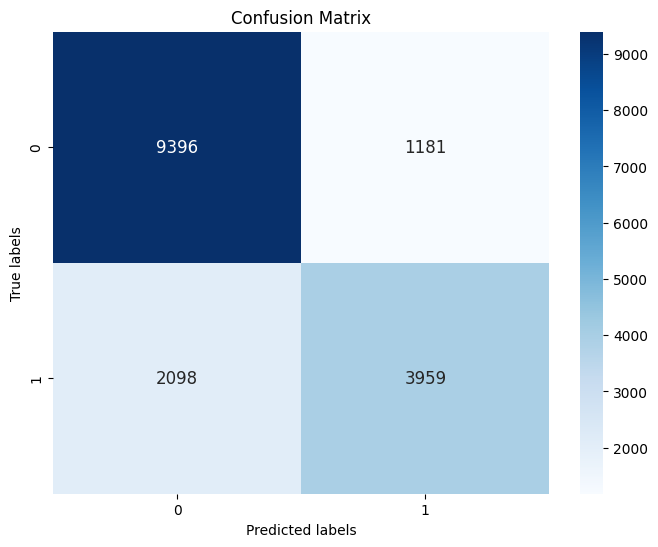

In [46]:
final_model = XGBClassifier(max_depth = None, learning_rate = 0.1, n_estimators = 300,subsample = 0.8 )

final_model.fit(preprocessor.transform(xtrain), ytrain)

ypred = final_model.predict(preprocessor.transform(xtest))

f1 = f1_score(ytest, ypred, average='binary', pos_label=1)  
accuracy = accuracy_score(ytest, ypred)
print(f"Final Model Test F1 Score: {f1:.4f}")
print(f"Final Model Test Accuracy: {accuracy:.4f}")
print("Classification Report:\n", classification_report(ytest, ypred))

conf_matrix = confusion_matrix(ytest, ypred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', annot_kws={"size": 12})
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [56]:
total_data = 16634
data_kelas_0 = 10577
data_kelas_1 = 6057

recall_kelas_0 = 0.89
recall_kelas_1 = 0.65

prediksi_benar_kelas_0 = recall_kelas_0 * data_kelas_0
prediksi_benar_kelas_1 = recall_kelas_1 * data_kelas_1

# Menghitung total prediksi benar
total_prediksi_benar = prediksi_benar_kelas_0 + prediksi_benar_kelas_1

# Menghitung akurasi penggunaan model
akurasi_model = total_prediksi_benar / total_data

# Menghitung akurasi tanpa model (prediksi kelas mayoritas)
akurasi_tanpa_model = data_kelas_0 / total_data

print(f'Akurasi Model : {akurasi_model:.3f}')
print(f'Akurasi Tanpa Model : {akurasi_tanpa_model:.3f}')


Akurasi Model : 0.803
Akurasi Tanpa Model : 0.636


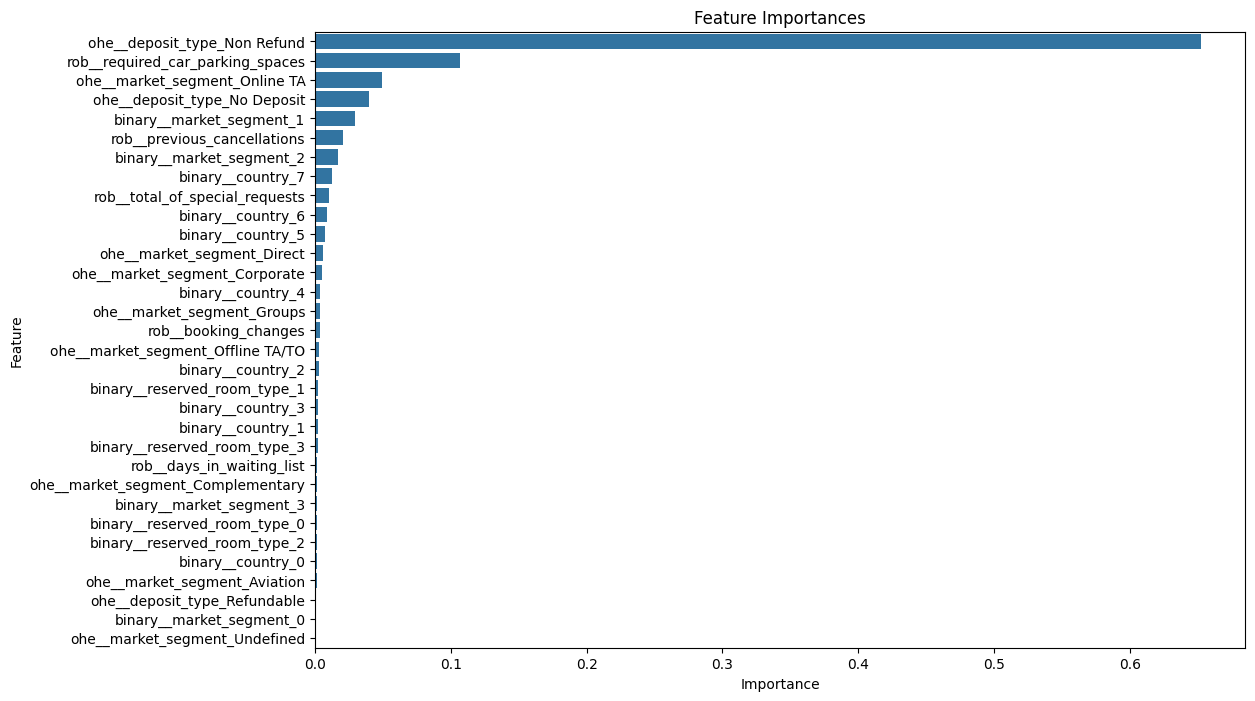

In [47]:
# Feature Importance
feature_importances = final_model.feature_importances_
feature_names = preprocessor.get_feature_names_out()

# Create a DataFrame for better visualization
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

# Sort the DataFrame by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importances')
plt.show()

Feature yang berpengaruh terhadap pembatalan bookingan
- `Deposit Type` = 'Non-Refund' dan 'No Deposit'
- `required parking spaces`
- `Market Segment` = 'Online TA'
- `Previous Cancelations`


# Pickle

model yang telah ditentukan di save menjadi file pickle

In [49]:
final_pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=2024)),
    ('xgb', XGBClassifier(max_depth = None, learning_rate = 0.1, n_estimators = 300,subsample = 0.8 ))
])

final_pipeline.fit(xtrain, ytrain)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('ohe',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['market_segment',
                                                   'deposit_type']),
                                                 ('binary', BinaryEncoder(),
                                                  ['country', 'market_segment',
                                                   'reserved_room_type']),
                                                 ('rob', RobustScaler(),
                                                  ['previous_cancellations',
                                                   'booking_changes',
                                                   'days_in_waiting_list',
                                                   'required_car_parking_spaces',
                                                   'total_of...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.1,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=300, n_jobs=None,
                               num_parallel_tree=None, random_state=None, ...))])

In [50]:
pickle.dump(final_pipeline, open('capstone3_gyo.sav', 'wb'))

# Kesimpulan 

- Model terbaik untuk kasus hotel booking cancelation ini dengan menggunakan `XGB Boost` dengan parameter
    - `max_depth`: None, 
    - `learning_rate`: 0.1, 
    - `n_estimators`: 300, 
    - `subsample`: 0.8
- Model ini dapat membantu management hotel untuk memprediksi customer yang akan membatalkan bookingan ataupun tidak dengan akurasi sebesar 80% dengan prediksi tanpa model memiliki akurasi sebesar 63%
- Model ini juga dapat membantu management hotel untuk memprediksi kapan terjadinya high/peak season dengan bookingan yang masuk dengan ratio cancelation, selain itu juga dapat melakukan maintenance ketika low season

# Recommendation

- Telah diketahui feature mana saja yang mempengaruhi booking dibatalkan, management hotel dapat membuat sebuah kebijakan atau promosi yang dapat menarik customer sehingga tidak membatalkan booking (Contoh: Booking yang Non-Refund)
- Melakukan Maintenance atau upgrade fasilitas berdasarkan special request customer dan mengacu ke high/low season
